# Hello there, today we will be selling some health insurance!🚑

**Disclaimer: I have not done any EDA and just focused on building models for this dataset!**

**Reminder - If you like my work don't forget to upvote and provide your feedback for any improvement!!**

**Now, let's jump into it!!**

**Let's first read the dataset**

In [ ]:
import pandas as pd 

df = pd.read_csv('../input/health-insurance-cross-sell-prediction/train.csv')
df.head()

In [ ]:
df.info()

**NO Null Values - Great!!**

**Let's one-hot encode the categorical columns!**

In [ ]:
X = pd.get_dummies(df)
X.info()

In [ ]:
X.Response.value_counts()

**OHH NO!! - The dataset is highly imbalanced! Let's upsample the minority class!**

In [ ]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = X[X.Response==0]
df_minority = X[X.Response==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=334399,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Response.value_counts()

**Perfect! Now, let's split the train data and labels as well as rename few columns becuase XGBoost doesn't allow '>' or '<' signs!**

In [ ]:
y = df_upsampled.Response

df_upsampled.drop(columns=['Response','id'],inplace=True,axis=1)

df_upsampled.rename({'Vehicle_Age_< 1 Year': 'Vehicle_Age_less_than 1 Year' , 'Vehicle_Age_> 2 Years': 'Vehicle_Age_greater_than 2 Years'},axis=1, inplace=True)

df_upsampled.info()

In [ ]:
df_upsampled.head()

**Now, let's scale down the data to be in range of 0-1. Most of the columns are already in that range so just a few needs to be scaled!**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_upsampled[df_upsampled.columns] = scaler.fit_transform(df_upsampled[df_upsampled.columns])

df_upsampled.head()

**Let's split the data into train and test!**

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(df_upsampled , y , test_size = 0.33 , random_state =123)

In [ ]:
X_train.shape, X_test.shape

**That is a huge train and test data, perfect for training and evaluation**

# Training

**I haven't trained any models on kaggle due to large size of data, instead I have trained it on my local pc and pasted the results!!**

**It was taking almost 10-12 min on my RTX2060 so it didn't make any sense to train on Kaggle!!**

# **XGBoost**

In [ ]:
from xgboost import *

xgb = XGBClassifier(max_depth = 6, 
                            n_estimators = 30000, 
                            objective = 'binary:logistic',colsample_bytree = 0.5, gamma = 0.3 , reg_lambda = 1.2, reg_alpha = 1.2, min_child_weight = 1, 
               learning_rate = 0.1,eval_metric = 'auc' ,tree_method='gpu_hist', gpu_id=0).fit(X_train,y_train)



In [ ]:
from sklearn.metrics import roc_auc_score 
Cat_preds1 = xgb.predict_proba(X_train)
Cat_class1 = xgb.predict(X_train)
Cat_score1 = roc_auc_score(y_train, Cat_preds1[:,1])
print(Cat_score1)

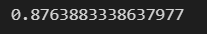

In [ ]:
Cat_preds1 = xgb.predict_proba(X_test)
Cat_class1 = xgb.predict(X_test)
Cat_score1 = roc_auc_score(y_test, Cat_preds1[:,1])
print(Cat_score1)

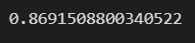

**We get a very decent accuracy by XGBoost although I didn't extensively fine tune the model!**

# **CatBoost**

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations = 30000, 
                                random_seed = 69, 
                                 task_type = 'GPU',
                                learning_rate=0.25,
                                depth=8,
                                loss_function='Logloss',
                                bootstrap_type='Poisson',
                                subsample = 0.8,
                                custom_loss = ['AUC'] ).fit(X_train, y_train)


In [ ]:
from sklearn.metrics import roc_auc_score
Cat_preds1 = cat.predict_proba(X_train)
Cat_class1 = cat.predict(X_train)
Cat_score1 = roc_auc_score(y_train, Cat_preds1[:,1])
print(Cat_score1)

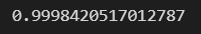

In [ ]:
Cat_preds1 = cat.predict_proba(X_test)
Cat_class1 = cat.predict(X_test)
Cat_score1 = roc_auc_score(y_test, Cat_preds1[:,1])
print(Cat_score1)

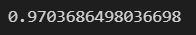

**Now we are talking - CatBoost gives almost a perfect score while training and reaches 97% accuracy on test set!**

**I also found out that without Scaling the data, the same model was able to achieve 99.4% accuracy on test set!!**

**Now let's plot the feature importance!!**

In [ ]:
feat_importances = pd.Series(cat.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

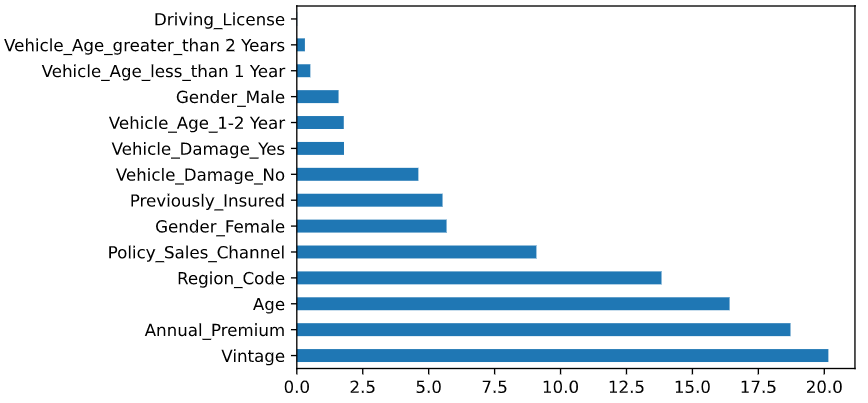

# So we can conclude by saying - Vintage (i.e. Number of Days, Customer has been associated with the company) is the most important factor followed by annual premium and age!

# **Thanks for reading through it , any questions, comments, suggestions are highly appreciated!**